In [1]:
import os
import math
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, BasicIterativeMethod
from art.estimators.classification import PyTorchClassifier
from art.utils import load_mnist

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split

from scipy.special import softmax


# Prepare data

In [2]:
def prepare_data(df):

    train = df[df["is_train"] == 1]
    test = df[df["is_train"] == 0]

    Y_train = train["target"].values
    X_train = train.drop(columns=["name", "prediction", "is_train", "target"]).to_numpy()

    Y_test = test["target"].values
    X_test = test.drop(columns=["name", "prediction", "is_train", "target"]).to_numpy()

    X_columns = train.drop(columns=["name", "prediction", "is_train", "target"]).columns

    sc = MinMaxScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    Y_train_one = np.zeros((Y_train.size, Y_train.max() + 1))
    Y_train_one[np.arange(Y_train.size), Y_train] = 1

    Y_test_one = np.zeros((Y_test.size, Y_test.max() + 1))
    Y_test_one[np.arange(Y_test.size), Y_test] = 1

    return X_train, X_test, Y_train, Y_test, Y_train_one, Y_test_one, list(X_columns)

In [3]:
class TabDataModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 128)
        self.linear3 = nn.Linear(128, 96)
        self.linear4 = nn.Linear(96, 32)
        self.linear5 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.25)
    def forward(self, x):
        return self.linear5(self.relu(self.linear4(self.dropout(self.relu(self.linear3(self.dropout(self.relu(self.linear2(self.dropout(self.relu(self.linear1(x))))))))))))
    
class TabDataModel2(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.input = nn.Linear(input_dim, 32)
        self.relu = nn.ReLU()
        self.output = nn.Linear(32, num_classes)
    def forward(self, x):
        return self.output(self.relu(self.input(x)))

In [4]:
dataset = "cmc"

df = pd.read_csv(f"data/{dataset}.csv")

X_train, X_test, Y_train, Y_test, Y_train_one, Y_test_one, X_columns = prepare_data(df)

# Train neural network

In [5]:
x_data = torch.tensor(X_train, dtype=torch.float32)
y_data = torch.tensor(Y_train_one, dtype=torch.float32)

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size=0.20, shuffle=True, random_state=123)

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_pred) * 100
    return acc

def multi_acc(y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    
    acc = torch.round(acc * 100)
    
    return acc

def save_model(path, model):
    os.makedirs(path, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(path, "torch_model.pth"))

def load_model(path, model):
    model.load_state_dict(torch.load(path, weights_only=True))
    model.eval()

_, cnt = np.unique(Y_train, return_counts=True)
class_weights = torch.tensor(1/cnt)

Epoch:    0 | Train Loss: 2.31644, Accuracy: 0.09% | Validation Loss: 2.29423, Accuracy: 0.16%
Epoch:  250 | Train Loss: 0.23207, Accuracy: 0.90% | Validation Loss: 0.40528, Accuracy: 0.81%
Epoch:  500 | Train Loss: 0.15978, Accuracy: 0.92% | Validation Loss: 0.43401, Accuracy: 0.81%
Epoch:  750 | Train Loss: 0.13436, Accuracy: 0.94% | Validation Loss: 0.50003, Accuracy: 0.81%
Epoch: 1000 | Train Loss: 0.12303, Accuracy: 0.94% | Validation Loss: 0.55806, Accuracy: 0.81%
Epoch: 1250 | Train Loss: 0.11692, Accuracy: 0.94% | Validation Loss: 0.62964, Accuracy: 0.79%
Epoch: 1500 | Train Loss: 0.11144, Accuracy: 0.94% | Validation Loss: 0.67211, Accuracy: 0.80%
Epoch: 1750 | Train Loss: 0.10789, Accuracy: 0.94% | Validation Loss: 0.72920, Accuracy: 0.78%
Epoch: 2000 | Train Loss: 0.10384, Accuracy: 0.94% | Validation Loss: 0.76309, Accuracy: 0.78%
Epoch: 2250 | Train Loss: 0.10169, Accuracy: 0.95% | Validation Loss: 0.81515, Accuracy: 0.79%
Epoch: 2500 | Train Loss: 0.10053, Accuracy: 0.95%

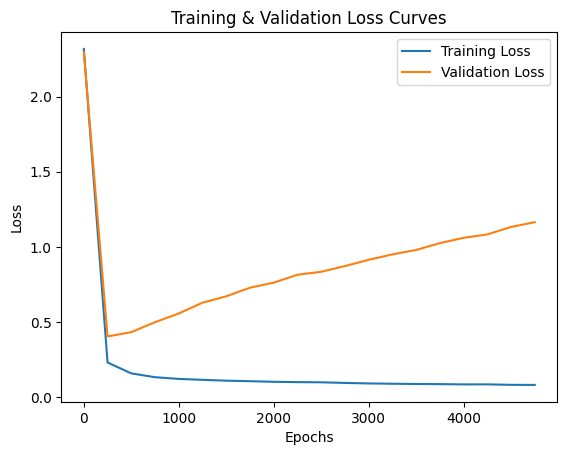

In [6]:
# https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
# https://machinelearningmastery.com/building-a-multiclass-classification-model-in-pytorch/
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

recalculate = True

n_features = X_test.shape[1]
n_class = len(np.unique(df["target"].values))
model = TabDataModel2(n_features, n_class)

learning_rate = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# loss_fn = nn.BCEWithLogitsLoss()
# optimizer = optim.SGD(params=model.parameters(), lr=learning_rate)

if recalculate: #  and not os.path.exists(f"results_nn/{dataset}/model/torch_model.pth"):

    epoch_count, train_loss_values, valid_loss_values = [], [], []

    epochs = 5000

    # Loop through the data
    for epoch in range(epochs):

        # Put the model in training mode
        model.train()

        y_train_pred = model(x_train)
        # y_pred_softmax = torch.log_softmax(y_train_pred, dim = 1)
        # _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)

        acc = accuracy_score(torch.argmax(y_train, 1), torch.argmax(y_train_pred, 1)) #  == torch.argmax(y_train, 1)).float().mean() # multi_acc(y_train_pred, y_train) # calculate the accuracy; convert the labels to integers
        loss = loss_fn(y_train_pred, y_train)

        optimizer.zero_grad() # reset the gradients so they don't accumulate each iteration
        loss.backward() # backward pass: backpropagate the prediction loss
        optimizer.step() # gradient descent: adjust the parameters by the gradients collected in the backward pass
        
        # Put the model in evaluation mode
        model.eval() 

        with torch.inference_mode():
            y_valid_pred = model(x_valid)    

            valid_loss = loss_fn(y_valid_pred, y_valid)
            valid_acc = accuracy_score(torch.argmax(y_valid, 1), torch.argmax(y_valid_pred, 1)) # (torch.argmax(y_valid_pred, 1) == torch.argmax(y_valid, 1)).float().mean() # multi_acc(y_valid_pred, y_valid)    
        
        # Print progress a total of 20 times
        if epoch % int(epochs / 20) == 0:
            print(f'Epoch: {epoch:4.0f} | Train Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Validation Loss: {valid_loss:.5f}, Accuracy: {valid_acc:.2f}%')

            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            valid_loss_values.append(valid_loss.detach().numpy())

    plt.plot(epoch_count, train_loss_values, label='Training Loss')
    plt.plot(epoch_count, valid_loss_values, label='Validation Loss')
    plt.title('Training & Validation Loss Curves')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

    # save_model(f"results_nn/{dataset}/model", model)
# else:
    # load_model(f"results_nn/{dataset}/model/torch_model.pth", model)

In [7]:
# Y_train = torch.Tensor.numpy(y_train)
# Y_train = Y_train.astype(np.int32)
# Y_train_one = np.zeros((Y_train.size, Y_train.max() + 1))
# Y_train_one[np.arange(Y_train.size), Y_train] = 1

# Y_test = torch.Tensor.numpy(y_valid)
# Y_test = Y_test.astype(np.int32)
# Y_test_one = np.zeros((Y_test.size, Y_test.max() + 1))
# Y_test_one[np.arange(Y_test.size), Y_test] = 1

In [10]:
# device = torch.device("cuda:0")
# loss_fn = nn.CrossEntropyLoss(weight=class_weights).to(device)

classifier = PyTorchClassifier(
    model=model,
    loss=loss_fn,
    optimizer=optimizer,
    input_shape=(1, 1, n_features),
    nb_classes=n_class,
)

In [11]:
X_test = X_test.astype(np.float32)
X_train = X_train.astype(np.float32)

predictions = classifier.predict(X_train)
predictions_score_tr = softmax(predictions, axis=1)
predictions_class_tr = [np.argmax(x) for x in predictions]
accuracy_tr = accuracy_score(Y_train, predictions_class_tr)
bacc_tr = balanced_accuracy_score(Y_train, predictions_class_tr)
print(f"Accuracy on benign train examples: {accuracy_tr * 100}%, balanced accuracy {bacc_tr * 100}%")

predictions = classifier.predict(X_test)
predictions_score = softmax(predictions, axis=1)
predictions_class = [np.argmax(x) for x in predictions]
accuracy = accuracy_score(Y_test, predictions_class)
bacc = balanced_accuracy_score(Y_test, predictions_class)
print(f"Accuracy on benign test examples: {accuracy * 100}%, balanced accuracy {bacc * 100}%")

# # Step 6: Generate adversarial test examples
# attack = FastGradientMethod(estimator=classifier, eps=0.2)
# x_test_adv = attack.generate(x=X_test)

# # Step 7: Evaluate the ART classifier on adversarial test examples

# predictions_adv = classifier.predict(x_test_adv)
# predictions_class_adv = np.round([sigmoid(x[0]) for x in predictions_adv])
# accuracy = accuracy_score(Y_test, predictions_class_adv)
# print("Accuracy on adversarial test examples: {}%".format(accuracy * 100))

Accuracy on benign train examples: 91.75%, balanced accuracy 91.94703599334149%
Accuracy on benign test examples: 81.25%, balanced accuracy 79.39483118453924%


# Attacks

In [ ]:
def attack(classifier, attack_type, X_test):
    fgm_range = np.arange(0.0, 2, 0.1)
    fgm_acc=[]
    for eps in fgm_range:
        if attack_type == "FGM":
            attack = FastGradientMethod(estimator=classifier, eps=eps)
        elif attack_type == "BIM":
            attack = BasicIterativeMethod(estimator=classifier, eps=eps, eps_step=0.1, max_iter=100, targeted=False, verbose=True)
        elif attack_type == "PGD":
            # attack = ProjectedGradientDescent(estimator=classifier, eps=eps)
            attack = ProjectedGradientDescent(estimator=classifier, eps=eps, eps_step=0.1, max_iter=100, num_random_init=1, targeted=False, verbose=True)
        # X_test = torch.tensor(X_test, dtype=torch.float32)
        x_test_adv = attack.generate(x=X_test)

        predictions_adv = classifier.predict(x_test_adv)
        predictions_score_adv = softmax(predictions_adv, axis=1)
        predictions_class_adv = [np.argmax(x) for x in predictions_adv]
        accuracy = accuracy_score(Y_test, predictions_class_adv)
        bacc = balanced_accuracy_score(Y_test, predictions_class_adv)
        fgm_acc.append(accuracy)
    
    '''PLOT'''
    plt.figure(figsize=(10,5))
    plt.title(attack_type)
    plt.ylabel('Accuracy')
    plt.xlabel('Epsilon')
    plt.ylim((0,1))
    plt.plot(fgm_range, fgm_acc)
    
    plt.show()
    print(f"Accuracy on adversarial test examples with {attack_type} attack: {accuracy * 100}%, balanced accuracy {bacc * 100}%")
    print(f"Steps of accuracy {fgm_acc}")
    return x_test_adv, predictions_class_adv, predictions_score_adv, accuracy, bacc

## FGM

This attack was originally implemented by Goodfellow et al. (2015) with the infinity norm (and is known as the “Fast Gradient Sign Method”). This implementation extends the attack to other norms, and is therefore called the Fast Gradient Method.

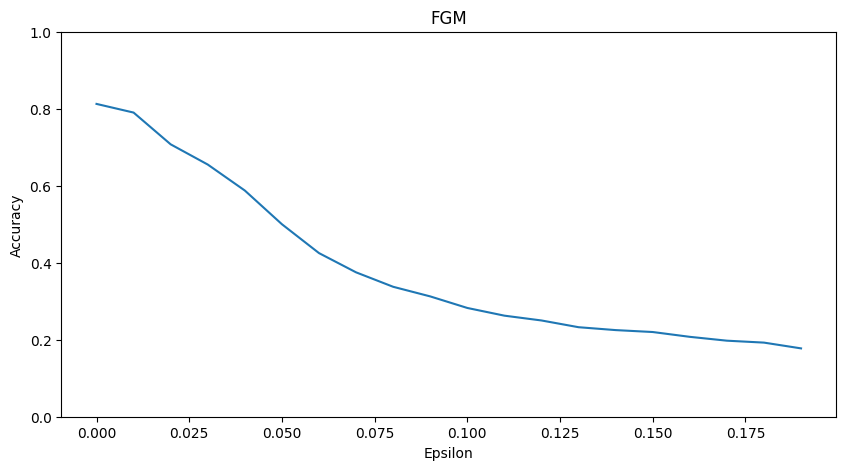

Accuracy on adversarial test examples with FGM attack: 17.75%, balanced accuracy 18.158472266092257%
Steps of accuracy [0.8125, 0.79, 0.7075, 0.655, 0.5875, 0.5, 0.425, 0.375, 0.3375, 0.3125, 0.2825, 0.2625, 0.25, 0.2325, 0.225, 0.22, 0.2075, 0.1975, 0.1925, 0.1775]


In [17]:
x_test_adv_fgm, y_test_pred_fgm, y_test_score_fgm, acc_fgm, bacc_fgm = attack(classifier, "FGM", X_test)

## PGD

The Projected Gradient Descent attack is an iterative method in which, after each iteration, the perturbation is projected on an lp-ball of specified radius (in addition to clipping the values of the adversarial sample so that it lies in the permitted data range). This is the attack proposed by Madry et al. for adversarial training.

Paper link: https://arxiv.org/abs/1706.06083

In [7]:
x_test_adv_pgd, y_test_pred_pgd, y_test_score_pgd, acc_pgd, bacc_pgd = attack(classifier, "PGD", X_test)

NameError: name 'attack' is not defined

## BIM

The Basic Iterative Method is the iterative version of PGD

BIM inherits po PGD https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/art/attacks/evasion/iterative_method.py
Mistake in the docs: https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#basic-iterative-method-bim

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/31 [00:00<?, ?it/s]

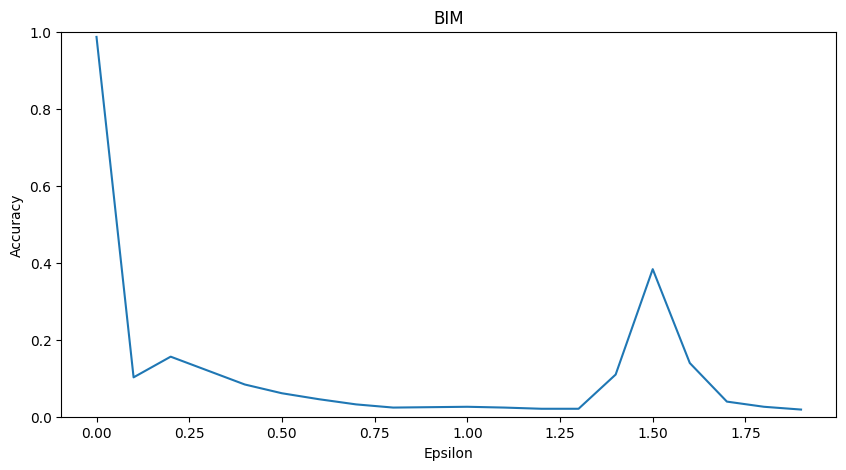

Accuracy on adversarial test examples with BIM attack: 1.859504132231405%, balanced accuracy 6.111719605695509%
Steps of accuracy [0.9865702479338843, 0.10227272727272728, 0.1559917355371901, 0.11983471074380166, 0.08367768595041322, 0.060950413223140494, 0.045454545454545456, 0.03202479338842975, 0.023760330578512397, 0.024793388429752067, 0.025826446280991736, 0.023760330578512397, 0.02066115702479339, 0.02066115702479339, 0.10950413223140495, 0.38326446280991733, 0.13946280991735538, 0.03925619834710744, 0.025826446280991736, 0.01859504132231405]


In [391]:
x_test_adv_bim, y_test_pred_bim, y_test_score_bim, acc_bim, bacc_bim = attack(classifier, "BIM", X_test)

## Random noise

In [392]:
def generate_clipped_noise(test_data, euclidean_distance,scaling_factor):
    # Generate random noise from a Gaussian distribution with mean 0 and standard deviation 1
    noise = np.random.normal(0, 1,size=(test_data.shape))
    scaled_noise = noise * scaling_factor
    scaled_noise_norm = np.linalg.norm(scaled_noise)
    scaled_noise = scaled_noise * (euclidean_distance / scaled_noise_norm)
    noisy_test_data = test_data + scaled_noise
    return noisy_test_data

def robust_accuracy(classifier, X_test, y_test, euclidean_distance,scaling_factor):
    noise_data = generate_clipped_noise(X_test, euclidean_distance,scaling_factor)
    noise_data = noise_data.astype(np.float32)
    y_pred = classifier.predict(noise_data)
    y_pred_score = softmax(y_pred, axis=1) 
    y_pred_class = [np.argmax(x) for x in y_pred]
    # Measure accuracy on which we added noise
    robust_accuracy = accuracy_score(y_test, y_pred_class)
    robust_bacc = balanced_accuracy_score(y_test, y_pred_class)
    return noise_data, y_pred_class, y_pred_score, robust_accuracy, robust_bacc

euclidean_distances = [0.05,0.1,0.5,1,5,10,20,30,50,100,150,200]
test_data_norm = np.linalg.norm(X_test)

In [393]:
robust_accuracy_results = []
scalings = []
for euclidean_distance in euclidean_distances:
    scaling_factor = euclidean_distance / test_data_norm 
    x_test_noise, y_test_pred_noise, y_test_score_noise, acc_noise, bacc_noise = robust_accuracy(classifier, X_test, Y_test, euclidean_distance, scaling_factor)
    robust_accuracy_results.append(acc_noise)
    scalings.append(scaling_factor)

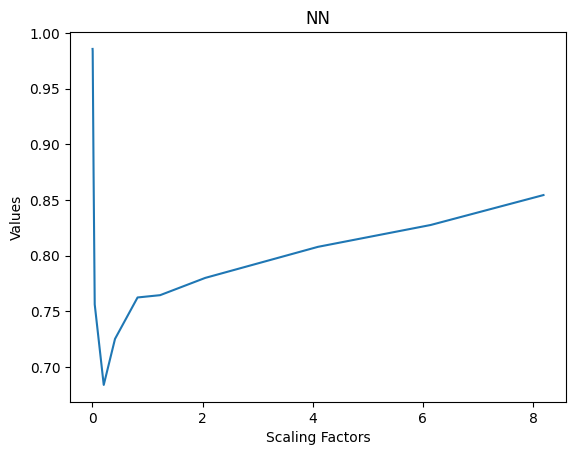

,0.05,0.10,0.50,1.00,5.00,10.00,20.00,30.00,50.00,100.00,150.00,200.00
Robust_Accuracy,0.985537,0.983471,0.872934,0.756198,0.683884,0.725207,0.762397,0.764463,0.779959,0.807851,0.827479,0.854339
Scaling_Factor,0.002048,0.004096,0.020478,0.040956,0.204781,0.409562,0.819125,1.228687,2.047812,4.095625,6.143437,8.191250


In [394]:
plt.plot(scalings, robust_accuracy_results)
plt.xlabel('Scaling Factors')
plt.ylabel('Values')
plt.title('NN')
plt.show()
robust_df = pd.DataFrame(np.vstack((robust_accuracy_results, scalings)),columns=euclidean_distances).rename(index={0: "Robust_Accuracy", 1: "Scaling_Factor"})
robust_df

In [24]:
def prepare_data_to_bb(x_test_adv, y_test_adv, y_score_adv):
    # name,is_train,target,prediction,score_0,score_1
    test_final = pd.DataFrame(x_test_adv, columns=X_columns)
    test_final["name"] = df[df["is_train"] == 0]["name"].values
    test_final["is_train"] = 0
    test_final["target"] = df[df["is_train"] == 0]["target"].values
    test_final["prediction"] = y_test_adv
    for i in range(y_score_adv.shape[1]):
        test_final[f"score_{i}"] = list(y_score_adv[:,i])
    
    train_final = pd.DataFrame(X_train, columns=X_columns)
    train_final["name"] = df[df["is_train"] == 1]["name"].values
    train_final["is_train"] = 1
    train_final["target"] = df[df["is_train"] == 1]["target"].values
    train_final["prediction"] = predictions_class_tr
    for i in range(predictions_score_tr.shape[1]):
        train_final[f"score_{i}"] = list(predictions_score_tr[:,i])
    
    final = pd.concat([test_final, train_final])

    return final

# final_data = prepare_data_to_bb(x_test_adv_fgm, y_test_pred_fgm, y_test_score_fgm)

In [396]:
os.makedirs(f"results_nn/{dataset}/datasets/", exist_ok=True)
prepare_data_to_bb(X_test, predictions_class, predictions_score).to_csv(f"results_nn/{dataset}/datasets/org.csv", index=False)
prepare_data_to_bb(x_test_adv_fgm, y_test_pred_fgm, y_test_score_fgm).to_csv(f"results_nn/{dataset}/datasets/fgm.csv", index=False)
prepare_data_to_bb(x_test_adv_pgd, y_test_pred_pgd, y_test_score_pgd).to_csv(f"results_nn/{dataset}/datasets/pgd.csv", index=False)
prepare_data_to_bb(x_test_adv_bim, y_test_pred_bim, y_test_score_bim).to_csv(f"results_nn/{dataset}/datasets/bim.csv", index=False)
prepare_data_to_bb(x_test_noise, y_test_pred_noise, y_test_score_noise).to_csv(f"results_nn/{dataset}/datasets/noise.csv", index=False)

In [397]:
os.makedirs(f"results_nn/{dataset}/quality/", exist_ok=True)
dataset_model = ['train', 'test', 'noise', 'fgm', 'pgd', 'bim']
acc_values = [accuracy_tr, accuracy, acc_noise, acc_fgm, acc_pgd, acc_bim]
bacc_values = [bacc_tr, bacc, bacc_noise, bacc_fgm, bacc_pgd, bacc_bim]
quality_dict = {'dataset': dataset_model, 'acc': acc_values, 'bacc': bacc_values}
pd.DataFrame(quality_dict).to_csv(f"results_nn/{dataset}/quality/quality.csv", index=False)


# Case study

In [22]:
def attack(classifier, attack_type, X_test):
    fgm_range = np.arange(0.0, 0.2, 0.01)
    fgm_acc=[]
    for eps in fgm_range:
        attack = FastGradientMethod(estimator=classifier, eps=eps)
        x_test_adv = attack.generate(x=X_test)

        predictions_adv = classifier.predict(x_test_adv)
        predictions_score_adv = softmax(predictions_adv, axis=1)
        predictions_class_adv = [np.argmax(x) for x in predictions_adv]
        accuracy = accuracy_score(Y_test, predictions_class_adv)
        bacc = balanced_accuracy_score(Y_test, predictions_class_adv)
        fgm_acc.append(accuracy)
    
    '''PLOT'''
    plt.figure(figsize=(10,5))
    plt.title(attack_type)
    plt.ylabel('Accuracy')
    plt.xlabel('Epsilon')
    plt.ylim((0,1))
    plt.plot(fgm_range, fgm_acc)
    
    plt.show()
    print(f"Accuracy on adversarial test examples with {attack_type} attack: {accuracy * 100}%, balanced accuracy {bacc * 100}%")
    print(f"Steps of accuracy {fgm_acc}")
    return x_test_adv, predictions_class_adv, predictions_score_adv, accuracy, bacc

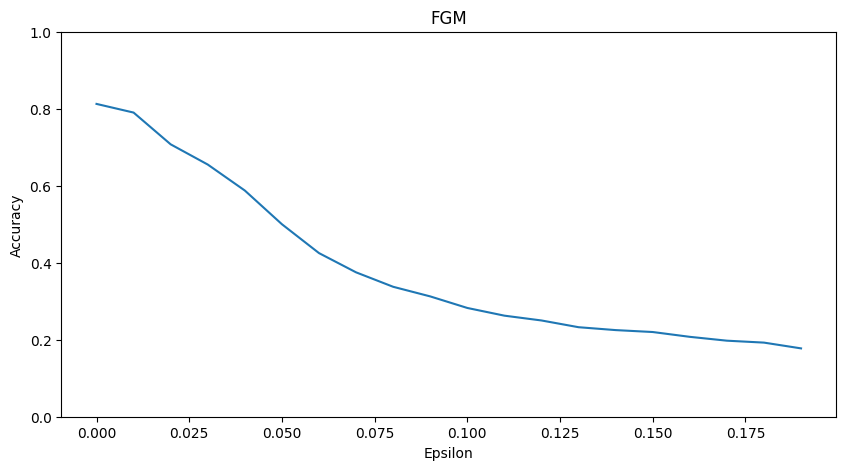

Accuracy on adversarial test examples with FGM attack: 17.75%, balanced accuracy 18.158472266092257%
Steps of accuracy [0.8125, 0.79, 0.7075, 0.655, 0.5875, 0.5, 0.425, 0.375, 0.3375, 0.3125, 0.2825, 0.2625, 0.25, 0.2325, 0.225, 0.22, 0.2075, 0.1975, 0.1925, 0.1775]


In [23]:
x_test_adv_fgm, y_test_pred_fgm, y_test_score_fgm, acc_fgm, bacc_fgm = attack(classifier, "FGM", X_test)

In [32]:
from tqdm import tqdm

prepare_data_to_bb(X_test, predictions_class, predictions_score).to_csv(f"results_nn_eps/{dataset}/datasets/org.csv", index=False)

fgm_range = np.arange(0.0, 0.2, 0.01)
for eps in tqdm(fgm_range):
    attack = FastGradientMethod(estimator=classifier, eps=eps)
    x_test_adv = attack.generate(x=X_test)

    predictions_adv = classifier.predict(x_test_adv)
    predictions_score_adv = softmax(predictions_adv, axis=1)
    predictions_class_adv = [np.argmax(x) for x in predictions_adv]

    eps_str = str(eps).replace(".", "_")

    prepare_data_to_bb(x_test_adv, predictions_class_adv, predictions_score_adv).to_csv(f"results_nn_eps/{dataset}/datasets/fgm_{eps_str}.csv", index=False)

100%|██████████| 20/20 [00:03<00:00,  6.39it/s]
